In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Prepare Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))
ind_val = int(0.8 * ind)

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)
s_train, p_train, s_val, p_val = split(s_train, p_train, ind_val)

In [4]:
s_train.shape, s_val.shape, s_test.shape

((640, 351), (160, 351), (201, 351))

# Test Utilities 

## Model generation 

In [5]:
dim_triu = dim * (dim + 1) // 2

In [6]:
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def build_model(activation, structure, learning_rate):



    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

    # hidden
    for layer in structure:

        model.add(keras.layers.Dense(
                layer, 
                activation=activation, 
                kernel_initializer=intializer, 
                #bias_initializer='zeros',
                #kernel_regularizer=keras.regularizers.l2(1e-8)
        ))


    #output
    model.add(keras.layers.Dense(dim_triu))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])
    
    return model

## Training 

In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=50, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-5, 
    cooldown=10, 
    min_lr=1e-10
)

In [8]:
n_tests = 5
n_resets = 3
epochs = 10000


def test_model(structure, activation, learning_rate=1e-4):
    error = []
    
    for i in range(n_tests):
        
        keras.backend.clear_session()
        model = build_model(activation, structure, learning_rate)
        
        for j in range(n_resets):
            keras.backend.set_value(model.optimizer.lr, learning_rate)
            
            history = model.fit(
                x = s_train,
                y = p_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(s_val, p_val), 
                verbose=0, 
                callbacks=[
                    early_stopping, 
                    reduce_lr
                ]
            )
        
        error.append(model.evaluate(s_test, p_test, verbose=0)[1])
        
        print(" - Test " + str(i+1) + ": " + str(error[-1]))
    
    return error

def run_layer_test_series(activation, structures, learning_rate):
    error = []
    for structure in structures:
        print("Layers: " + str(structure))
        error.append(test_model(structure, activation, learning_rate=learning_rate))
    return error

# Testing 

In [9]:
structures = [
        [dim_triu, dim_triu],
        [dim_triu, dim_triu, dim_triu],
        [dim_triu + 100, dim_triu + 100],
        [dim_triu + 250, dim_triu + 150, dim_triu + 50],
        [dim_triu + 100, dim_triu + 200, dim_triu + 100],
        [dim_triu, dim_triu, dim_triu, dim_triu, dim_triu]
    ]
        
learning_rates = [1e-3, 1e-4, 1e-5]

In [10]:
res = []
for lr in learning_rates:
    print("# lr" + str(lr))
    res.append(run_layer_test_series('elu', structures, lr))

# lr0.001
Layers: [351, 351]

Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-0


Epoch 00207: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00283: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00302: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00310: early stopping

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-0


Epoch 00201: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00220: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00258: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00334: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00353: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00391: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00395: early stopping

Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.000500000023748725


Epoch 00252: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00385: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 00391: early stopping

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05


Epoch 00289: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00308: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00327: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00346: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00365: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00384: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00401: early stopping
 - Test 5: 0.008045101306628232
Layers: [451, 451]

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00179: ReduceLROnPlat


Epoch 00321: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00331: early stopping

Epoch 00096: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00267: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07

Epoch 00408: early stopping

Epoch 00136: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00155: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00303: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00322: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00341: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00360: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07


Epoch 00186: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00319: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00358: early stopping

Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.00025000001187436


Epoch 00339: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00377: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00396: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00401: early stopping

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00356: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00894: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00913: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06


Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00190: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 00191: early stopping
 - Test 2: 0.060808691497317595

Epoch 00076: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00210: ReduceLROnPlateau reducing learnin


Epoch 00339: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00343: early stopping

Epoch 00153: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00255: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00298: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00317: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00336: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00355: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07


Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00076: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00122: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00160: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 00188: early stopping
 - Test 2: 0.06080653514731583

Epoch 00195: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00225: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00250: ReduceLROnPlateau reducing learning


Epoch 00076: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 00160: early stopping

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 00208: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00246: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00303: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00385: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00404: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00423: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00424: early stopping




Epoch 00277: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00283: early stopping

Epoch 00028: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00126: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00164: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

E


Epoch 00505: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00506: early stopping

Epoch 00062: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

E


Epoch 00149: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00282: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00320: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00339: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00377: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00396: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00415: ReduceLROnPlatea


Epoch 00104: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00180: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00199: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00256: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00262: early stopping
 - Test 3: 0.005880931042486904

Epoch 00166: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00204: ReduceLROnPlateau reducing learning


Epoch 00115: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00267: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00298: early stopping

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.




Epoch 00242: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00320: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00339: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00377: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00396: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00415: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00434: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00453: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00455: early stopping




Epoch 00111: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00168: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00206: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00225: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00244: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00251: early stopping
 - Test 1: 0.0063351367516860145

Epoch 00225: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00258: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00296: ReduceLROnPlateau reducing learning


Epoch 00156: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00270: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00277: early stopping

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

E

Epoch 00268: early stopping
 - Test 1: 0.008097169253585943

Epoch 00024: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00913: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00943: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00971: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00990: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 01009: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 01028: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 01047: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 01066: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 01085: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 01104: ReduceLROnPlateau reducing learning ra


Epoch 00614: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00633: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00652: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.

Epoch 00671: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.

Epoch 00690: ReduceLROnPlateau reducing learning rate to 3.051757735406113e-09.
Epoch 00695: early stopping

Epoch 00483: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00502: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00521: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00540: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00559: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00578: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00597: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

E


Epoch 00154: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.
Epoch 00206: early stopping
 - Test 1: 0.012087767443327761

Epoch 00702: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00721: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00740: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00759: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00778: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00797: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00816: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00835: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00854: ReduceLROnPlateau reducing learning ra


Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00220: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00229: early stopping
 - Test 4: 0.012545794684124824

Epoch 00705: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00724: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00743: ReduceLROnPlateau reducing learning r


Epoch 00188: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00244: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

E


Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00226: early stopping

Epoch 00020: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epo


Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00210: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Ep


Epoch 00940: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00959: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00978: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00997: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 01016: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 01035: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.
Epoch 01042: early stopping

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00113: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.



Epoch 00233: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.
Epoch 00254: early stopping
 - Test 3: 0.012934252110064326

Epoch 00690: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00715: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00736: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00755: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00774: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00793: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00812: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00831: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00850: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00869: ReduceLROnPlateau reducing learning 


Epoch 00104: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00180: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00199: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00225: early stopping
 - Test 1: 0.01335357086946122

Epoch 00798: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00826: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00845: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00864: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00883: ReduceLROnPlateau reducing learning rat


Epoch 00237: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 00256: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.
Epoch 00261: early stopping

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.




Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
Epoch 00080: early stopping

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
Epoch 00056: early stopping
 - Test 5: 0.06092216841765304


In [11]:
x = [ 
    s for s in range(len(structures)) for i in range(n_tests)
]

In [12]:
np.save("data/hyperpar_res.npy", res)
np.save("data/hyperpar_x.npy", x)
np.save("data/hyperpar_structures.npy", structures)
np.save("data/hyperpar_lr.npy", learning_rates)


In [13]:
def structure_string(structure):
    return "_".join(list(map(str,list(structure))))
structure_string(structures[0])

'351_351'

In [31]:
plt.rc("figure", figsize=(8,5))

array([0.001     , 0.00177828, 0.00316228, 0.00562341, 0.01      ,
       0.01778279, 0.03162278, 0.05623413, 0.1       ])

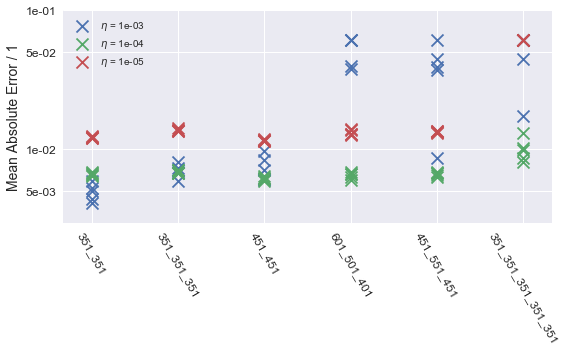

In [67]:
import matplotlib.ticker as mtick

fig = plt.figure()
ax = plt.gca()

for r, lr in zip(res, learning_rates):
    ax.scatter(x, np.array(r).flatten(), marker="x", label="$\eta$ = {:1.0e}".format(lr) )

ax.set_yscale('log')
#yticks = [2.5e-3, 5e-3, 7.5e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1]
yticks = [5e-3, 1e-2, 5e-2, 1e-1]
plt.yticks(yticks, yticks)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

#plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("Mean Absolute Error / 1")

plt.xticks(
    np.arange(len(structures)),
    [structure_string(structure) for structure in structures],
    rotation=-60
)
#yticks = [2e-3, 5e-3, 1e-2, 5e-2, 1e-1]
#plt.yticks(yticks, yticks)

#plt.ylim(0.0025, 0.015)
plt.legend()
#plt.legend(loc='upper right',bbox_to_anchor=(1.15, 1.))
plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/SMatrixDescriptor/figures/HyperparameterStudy.pdf")

plt.show()

In [ ]:
(5e-3)**2